Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 14.  Winter 2026.

<code>Colab</code> has mutltiple different runtime options in <code>Runtime > Change runtime type</code>.  The default is CPU (central processing unit), which is a general purpose process found in all computers.  They also have a GPU option and a TPU option.  A GPU is a graphical processing unit, which is designed to efficiently do linear algebra-type calculations found in video rendering calculations.  These are not as flexible as CPUs, but are great for training neural networks.  A TPU is a tensor processing unit, which is specifically designed for the calculations that appear when training machine learning models.  Again, not as versatile as a CPU, but great for machine learning.  Because RNNs can get pretty computationally heavy, it's a good idea to switch our runtime from CPU to GPU or TPU.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from tqdm.keras import TqdmCallback

We previously saw how we could convert a SMILES string into a vector of numbers that a convolutional neural net could interpret and use to predict aqueous solubility of the molecule.  Here we'll use that same input (SMILES string converted to padded numbers) with a few different recurrent neural network architectures.  A SMILES string is a sequence where the order has meaning, so thi is a reasonable task for a RNN.

The following code reads in the training and testing aqueous solubility data and builds padded numerical vectors for each SMILES string.

This is adapted from https://dmol.pub/dl/NLP.html.

In [2]:
#load training and testing data
df_train = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_test.csv')

#filter out long smiles
max_smile_length = 96
mask_train = [len(s) <= max_smile_length for s in df_train['SMILES']]
print('Removed '+str(df_train.shape[0] - sum(mask_train))+' long SMILES strings from training data.')
filtered_training_data = df_train[mask_train]

mask_test = [len(s) <= max_smile_length for s in df_test['SMILES']]
print('Removed '+str(df_test.shape[0] - sum(mask_test))+' long SMILES strings from test data.')
filtered_test_data = df_test[mask_test]

#figure out how many unique characters there are across all the SMILES
all_SMILES = pd.concat([filtered_training_data['SMILES'], filtered_test_data['SMILES']], ignore_index=True)
unique_count = len(set().union(*all_SMILES))+1

#the tokenizer will convert our characters into numbers
#filers='' means we won't filter any characters, every character in the SMILES string counts
#char_level=True means that we'll break the SMILES strings down into individual characters (as opposed to words for natural language processing)
#lower=False means that we distinguish between upper and lower case (lower case means the atom is in an aromatic ring)
tokenizer = tf.keras.preprocessing.text.Tokenizer(unique_count, filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(all_SMILES)

#we now convert our training and test SMILES to integer sequences with the tokenizer
train_seqs = tokenizer.texts_to_sequences(filtered_training_data['SMILES'])
test_seqs = tokenizer.texts_to_sequences(filtered_test_data['SMILES'])

#finally, we pad our sequences with zeros at the end so each is the same length
padded_train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
padded_test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

#build the training and test targets
y_train = filtered_training_data["Solubility"].values
y_test = filtered_test_data["Solubility"].values

Removed 257 long SMILES strings from training data.
Removed 28 long SMILES strings from test data.


Let's load up our CNN model from last time to give us a baseline model to compare with.

In [3]:
def graphs_and_analysis(model, history, X_train, X_test, y_train, y_test, title):
  #make predictions on the training and test data
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  #calculate the MSE on the training and test data
  mse_train = sklearn.metrics.mean_squared_error(y_pred_train, y_train)
  mse_test = sklearn.metrics.mean_squared_error(y_pred_test, y_test)

  #calculate R^2 on the training and test data
  R2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
  R2_test = sklearn.metrics.r2_score(y_test, y_pred_test)

  #set up plots
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  #plot the training predictions against actual solubility
  ax[0].scatter(y_train, y_pred_train, color='b', marker='x',label='train')
  ax[0].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
  ax[0].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
  ax[0].grid()
  ax[0].set_title('training, MSE= '+str(np.round(mse_train,decimals=3))+', R$^2=$ '+str(np.round(R2_train,decimals=3)),fontsize=16)

  #plot the test predictions against the actual solubility
  ax[1].scatter(y_test, y_pred_test, color='orange', marker='o',label='test')
  ax[1].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
  ax[1].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
  ax[1].grid()
  ax[1].set_title('testing, MSE= '+str(np.round(mse_test, decimals=3))+', R$^2=$ '+str(np.round(R2_test, decimals=3)),fontsize=16)
  fig.suptitle(title, fontsize=20)
  plt.tight_layout()


  fgi2, ax2 = plt.subplots(1, 1, figsize=(5, 5))

  ax2.plot(history.history['loss'], label='training', color='r')
  ax2.plot(history.history['val_loss'], label='validation',color='g')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('loss')
  ax2.legend(fontsize=14)
  ax2.grid()

  plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 10)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 30)         │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


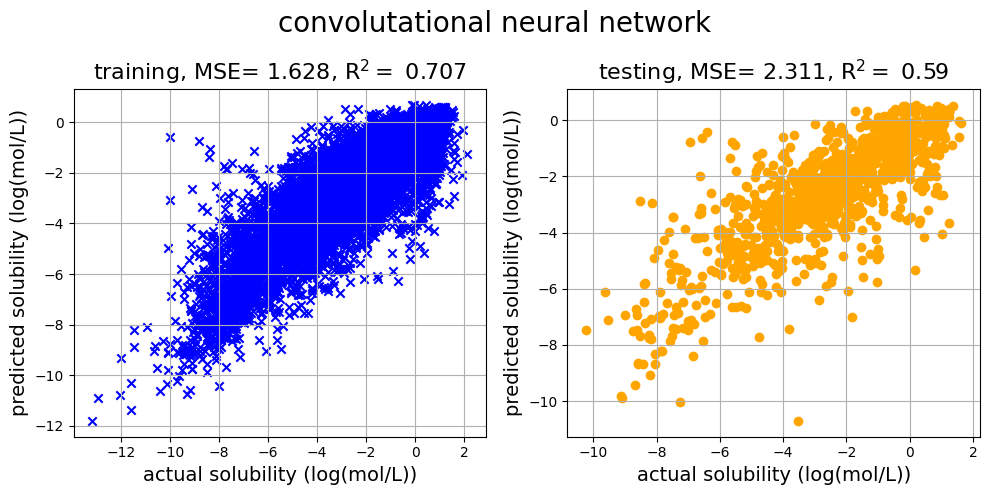

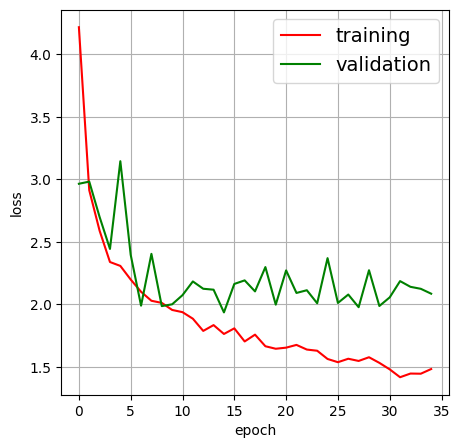

In [4]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,1)),
  #keras.layers.Embedding(input_dim=128, output_dim=16, input_length=96),

  keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=4),

  keras.layers.Flatten(),
  keras.layers.Dense(40, activation='relu'),

  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'convolutational neural network')

# Simple RNN

Let's see how an RNN with a simple recurrent structure does on the data.  We implement the layer with <code>Keras</code>'s <code>SimpleRNN</code>.  The number argument is the number of neurons.  We'll chose a ReLU activation.  And the <code>return_sequences=False</code> means that we'll only take the final output, which is useful for regression.  If we use <code>return_sequences=True</code>, then we will get the output at every step in the sequence and our output will be another sequence.

We'll also use a masking layer.  Since we are using padded sequences, any 0 values (which will appear at the end) are just placeholders.  By masking these values, the RNN will stop inputting the sequence once it gets to the zeros.  This helps with efficiency and also ensures that the RNN doesn't learn from the meaningless padding values.

After the RNN layer, we feed into a linear dense layer to do the final regression calulcation for the solubility.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,201 (20.32 KB)

 Trainable params: 5,201 (20.32 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


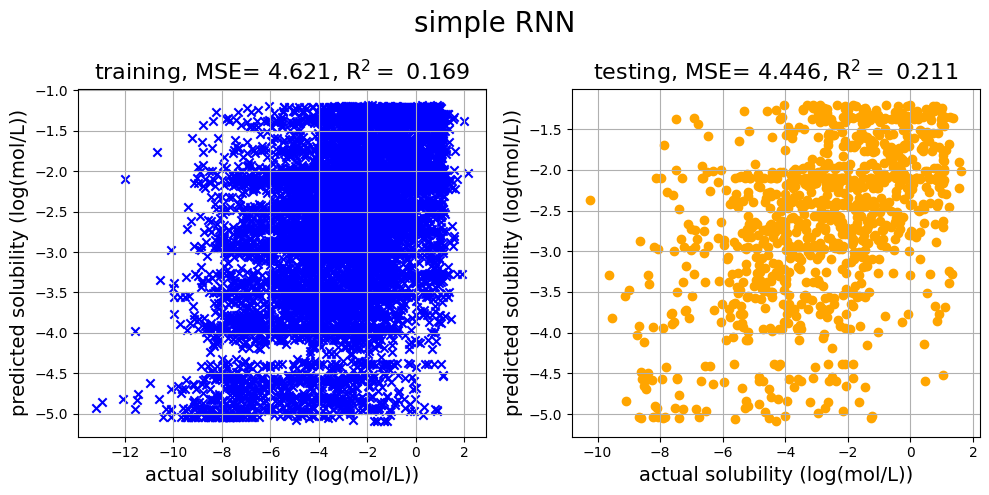

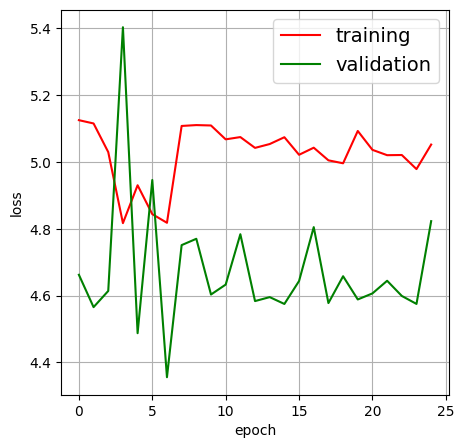

In [5]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,1)),
  keras.layers.Masking(mask_value=0),#mask padded 0 values
  keras.layers.SimpleRNN(50, return_sequences=False),#the default activation functions are activation='tanh' and recurrent_activation='sigmoid'
  keras.layers.Dense(50, activation='relu'),
  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=25, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'simple RNN')

This isn't great performance.  It certainly does worse than our CNN.  Let's see if going to a more sophisticated RNN layer helps.

# Gated Recurrent Unit (GRU)

Let's see the difference in performace with a GRU vs. our previous simple RNN.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,551 (41.21 KB)

 Trainable params: 10,551 (41.21 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


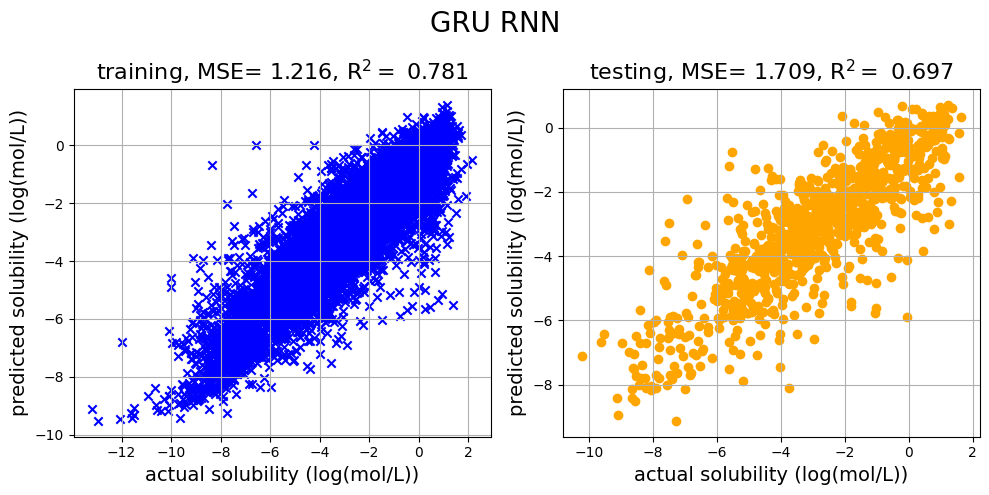

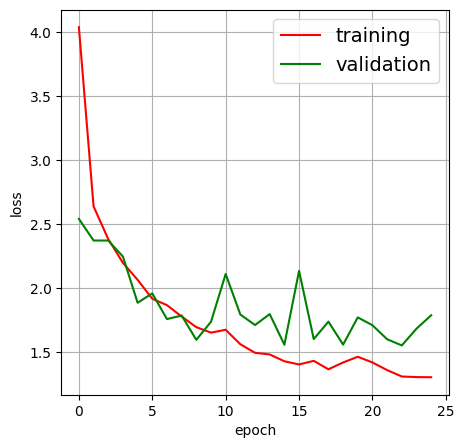

In [6]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,1)),
  keras.layers.Masking(mask_value=0),#mask padded 0 values
  keras.layers.GRU(50, return_sequences=False),#the default activation functions are activation='tanh' and recurrent_activation='sigmoid'
  keras.layers.Dense(50, activation='relu'),
  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=25, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'GRU RNN')

That's a lot better!

# Long Short-Term Memory

Now let's see how a LSTM layer performs.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


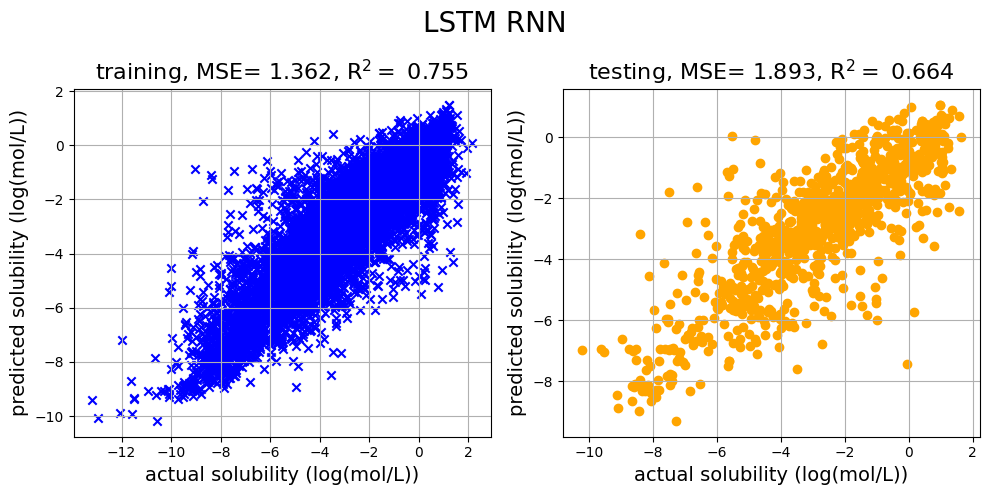

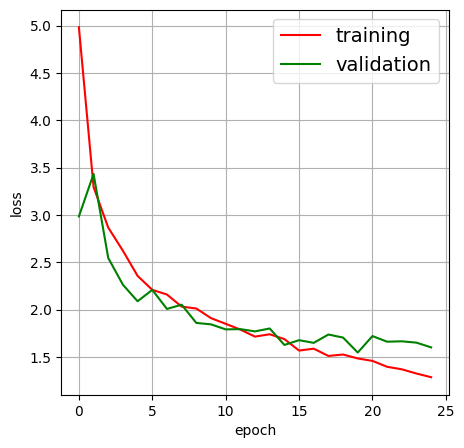

In [7]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,1)),
  keras.layers.Masking(mask_value=0),#mask padded 0 values
  keras.layers.LSTM(50, return_sequences=False),#the default activation functions are activation='tanh' and recurrent_activation='sigmoid'
  keras.layers.Dense(50, activation='relu'),
  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=25, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'LSTM RNN')

LSTM did about as well as GRU, but it also looks like we could let this training to go on longer and possibly end up with better performance.